In [60]:
#Import the Necessary Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier # Another implementation of new model
from sklearn.inspection import permutation_importance # For interpretability
from sklearn.ensemble import GradientBoostingClassifier # New model
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

Steps

Read in the DataFrame
Analyze the Data
Identify Target
Identify Nulls and determine what to do with them if they seem to be useful to Creating the Models
Identify Data Leakage columns
Clean and Wrangle the data 


Target = Sleep Quality Features which is affected by, Time in Bed, Wake up, Wake up-null, Sleep Notes, Heart Rate

So we are predicting Sleep Quality from Time in Bed, Sleep Notes, Heart Rate


In [61]:
#Import and read in the DataSet

Sleep = pd.read_csv("sleepdata1.csv",sep = ';')

In [62]:
#Look at the Data

Sleep.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0


In [63]:
#Drop Start and End Columns since the difference = Time in bed column
#Sleep.drop(columns=['Start', 'End'], inplace = True)

In [64]:
#Look at the Data

Sleep.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0


In [65]:
#Look for Null values

Sleep.isnull().sum()

Start                 0
End                   0
Sleep quality         0
Time in bed           0
Wake up             641
Sleep Notes         235
Heart rate          725
Activity (steps)      0
dtype: int64

In [66]:
Sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Start             887 non-null    object 
 1   End               887 non-null    object 
 2   Sleep quality     887 non-null    object 
 3   Time in bed       887 non-null    object 
 4   Wake up           246 non-null    object 
 5   Sleep Notes       652 non-null    object 
 6   Heart rate        162 non-null    float64
 7   Activity (steps)  887 non-null    int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 55.6+ KB


In [67]:
#Check value counts for the symbols under the Wakeup Col

Sleep['Wake up'].value_counts()

:)    216
:|     29
:(      1
Name: Wake up, dtype: int64

In [68]:
type(Sleep['Wake up'][0])

str

In [69]:
type(Sleep['Time in bed'][0])

str

In [70]:
import time
import datetime

Sleep['Start'] = pd.to_datetime(Sleep['Start'])
Sleep['End'] = pd.to_datetime(Sleep['End'])

In [71]:
Sleep['Start time'] = pd.Series([val.time() for val in Sleep['Start']])
Sleep['End time'] = pd.Series([val.time() for val in Sleep['End']])

Sleep['Start time in second'] = Sleep['Start time'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)
Sleep['End time in second'] = Sleep['End time'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)

Sleep['Time in Bed in Seconds'] = Sleep['End'] - Sleep['Start']
Sleep['Time in Bed in Seconds'] = Sleep['Time in Bed in Seconds'].astype('timedelta64[s]')

In [72]:
#Sleep['Time in bed in minutes'] = Sleep['Time in bed'].apply(lambda x: (x.hour*60+x.minute)*60)

In [73]:
Sleep

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),Start time,End time,Start time in second,End time in second,Time in Bed in Seconds
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0,22:57:49,07:30:13,82669,27013,30744.0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0,21:17:50,21:33:54,76670,77634,964.0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0,22:42:49,07:13:31,81769,26011,30642.0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0,22:31:01,06:03:01,81061,21781,27120.0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0,22:12:10,04:56:35,79930,17795,24265.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91%,9:08,NaN,NaN,NaN,56,21:54:14,07:02:15,78854,25335,32881.0
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81%,7:11,NaN,NaN,NaN,64,23:49:19,07:00:53,85759,25253,25894.0
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71%,8:56,NaN,NaN,NaN,3316,21:24:05,06:20:52,77045,22852,32207.0
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80%,9:13,NaN,NaN,NaN,6555,21:36:32,06:50:31,77792,24631,33239.0


In [74]:
#Change the content of the Column

Sleep['Wake up'] = Sleep['Wake up'].str.replace(':\)', 'Happy')
Sleep['Wake up'] = Sleep['Wake up'].str.replace(':\|', 'Okay')
Sleep['Wake up'] = Sleep['Wake up'].str.replace(':\(', 'Sad')

Sleep.head(50)

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),Start time,End time,Start time in second,End time in second,Time in Bed in Seconds
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,Happy,NaN,59.0,0,22:57:49,07:30:13,82669,27013,30744.0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,Okay,Stressful day,72.0,0,21:17:50,21:33:54,76670,77634,964.0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,Okay,NaN,57.0,0,22:42:49,07:13:31,81769,26011,30642.0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0,22:31:01,06:03:01,81061,21781,27120.0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,Happy,Drank coffee:Drank tea,68.0,0,22:12:10,04:56:35,79930,17795,24265.0
5,2015-01-03 00:34:57,2015-01-03 07:47:23,83%,7:12,Happy,Drank coffee:Drank tea,60.0,0,00:34:57,07:47:23,2097,28043,25946.0
6,2015-01-04 00:23:06,2015-01-04 07:37:09,78%,7:14,NaN,Drank tea,NaN,0,00:23:06,07:37:09,1386,27429,26043.0
7,2015-01-04 21:34:44,2015-01-05 04:53:34,78%,7:18,Happy,Ate late:Drank coffee,57.0,0,21:34:44,04:53:34,77684,17614,26330.0
8,2015-01-05 21:32:25,2015-01-06 05:00:03,69%,7:27,Happy,Drank coffee:Drank tea:Worked out,56.0,0,21:32:25,05:00:03,77545,18003,26858.0
9,2015-01-06 21:24:56,2015-01-07 05:00:02,74%,7:35,Okay,Drank tea:Worked out,64.0,0,21:24:56,05:00:02,77096,18002,27306.0


The SleepNotes Col seems like alot of activities put together in there, so we can clean it up by identifying the activities

I am going to feature engineer a bunch of columns to make data easier to interpret. Here we go!

In [75]:
Sleep['Wake_up_MISSING'] = Sleep['Wake up'].isnull().astype(int)
Sleep['SleepNotes_MISSING'] = Sleep['Sleep Notes'].isnull().astype(int)
Sleep['HeartRate_MISSING'] = Sleep['Heart rate'].isnull().astype(int)

Sleep['Activity (steps)'] =Sleep['Activity (steps)'].replace(0, np.nan)
Sleep['Activity (steps)_MISSING'] =Sleep['Activity (steps)'].isnull().astype(int)



In [76]:
#Activity List:Drank coffee Drank tea Worked out Stressful day Ate late
Activity_List = ['Drank coffee','Drank tea', 'Worked out','Stressful day','Ate late' ]

for Activity in Activity_List:
     Sleep[Activity] = [1 if row==row and Activity in row else 0 for row in Sleep['Sleep Notes']]
        

In [77]:
Sleep.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),Start time,End time,...,Time in Bed in Seconds,Wake_up_MISSING,SleepNotes_MISSING,HeartRate_MISSING,Activity (steps)_MISSING,Drank coffee,Drank tea,Worked out,Stressful day,Ate late
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,Happy,NaN,59.0,NaN,22:57:49,07:30:13,...,30744.0,0,1,0,1,0,0,0,0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,Okay,Stressful day,72.0,NaN,21:17:50,21:33:54,...,964.0,0,0,0,1,0,0,0,1,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,Okay,NaN,57.0,NaN,22:42:49,07:13:31,...,30642.0,0,1,0,1,0,0,0,0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,NaN,22:31:01,06:03:01,...,27120.0,1,1,1,1,0,0,0,0,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,Happy,Drank coffee:Drank tea,68.0,NaN,22:12:10,04:56:35,...,24265.0,0,0,0,1,1,1,0,0,0


In [78]:
Sleep['Sleep quality'] = Sleep['Sleep quality'].str.strip('%').astype(int)

In [79]:
Sleep.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),Start time,End time,...,Time in Bed in Seconds,Wake_up_MISSING,SleepNotes_MISSING,HeartRate_MISSING,Activity (steps)_MISSING,Drank coffee,Drank tea,Worked out,Stressful day,Ate late
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100,8:32,Happy,NaN,59.0,NaN,22:57:49,07:30:13,...,30744.0,0,1,0,1,0,0,0,0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3,0:16,Okay,Stressful day,72.0,NaN,21:17:50,21:33:54,...,964.0,0,0,0,1,0,0,0,1,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98,8:30,Okay,NaN,57.0,NaN,22:42:49,07:13:31,...,30642.0,0,1,0,1,0,0,0,0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65,7:32,NaN,NaN,NaN,NaN,22:31:01,06:03:01,...,27120.0,1,1,1,1,0,0,0,0,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72,6:44,Happy,Drank coffee:Drank tea,68.0,NaN,22:12:10,04:56:35,...,24265.0,0,0,0,1,1,1,0,0,0


In [80]:
Sleep.corr().T

,Sleep quality,Heart rate,Activity (steps),Start time in second,End time in second,Time in Bed in Seconds,Wake_up_MISSING,SleepNotes_MISSING,HeartRate_MISSING,Activity (steps)_MISSING,Drank coffee,Drank tea,Worked out,Stressful day,Ate late
Sleep quality,1.000000,-0.037846,-0.136605,0.234936,0.076523,0.695206,-0.076537,-0.158895,-0.102908,0.164848,0.107466,0.152647,0.039400,0.051173,0.022692
Heart rate,-0.037846,1.000000,NaN,-0.211327,0.241162,-0.054988,NaN,-0.052454,NaN,NaN,0.078282,-0.038011,-0.038387,0.126001,-0.049067
Activity (steps),-0.136605,NaN,1.000000,-0.068189,-0.072959,-0.114655,NaN,-0.182284,NaN,NaN,0.148451,0.193303,0.406889,0.068557,0.061752
Start time in second,0.234936,-0.211327,-0.068189,1.000000,-0.344245,0.398909,0.032542,-0.057736,0.012912,0.007324,0.014888,0.052453,0.032650,0.025427,0.025157
End time in second,0.076523,0.241162,-0.072959,-0.344245,1.000000,0.097175,0.150364,0.043065,0.058269,-0.139499,-0.032317,-0.069047,-0.183295,0.043469,-0.071283
Time in Bed in Seconds,0.695206,-0.054988,-0.114655,0.398909,0.097175,1.000000,0.068357,-0.130586,0.007194,-0.054200,0.057818,0.074154,0.004938,0.015622,-0.007611
Wake_up_MISSING,-0.076537,NaN,NaN,0.032542,0.150364,0.068357,1.000000,0.320561,0.763045,-0.656201,-0.310751,-0.239499,-0.128235,-0.141742,-0.069168
SleepNotes_MISSING,-0.158895,-0.052454,-0.182284,-0.057736,0.043065,-0.130586,0.320561,1.000000,0.237506,-0.464419,-0.721311,-0.617524,-0.500853,-0.158799,-0.093489
HeartRate_MISSING,-0.102908,NaN,NaN,0.012912,0.058269,0.007194,0.763045,0.237506,1.000000,-0.500711,-0.191668,-0.226036,-0.056470,-0.099231,-0.041544
Activity (steps)_MISSING,0.164848,NaN,NaN,0.007324,-0.139499,-0.054200,-0.656201,-0.464419,-0.500711,1.000000,0.445851,0.149616,0.295984,0.170546,0.090672


Text(0.5, 1.0, 'Correlation')

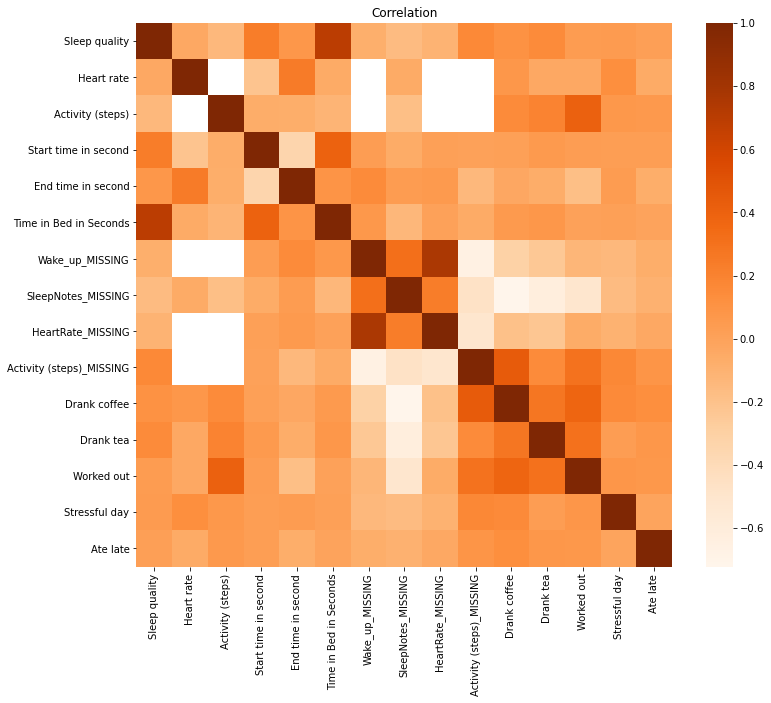

In [81]:
# visualisation of this correlation
fig = plt.figure(figsize = (12,10))
r = sns.heatmap(Sleep.corr(),cmap='Oranges')
# set title
r.set_title('Correlation')

In [82]:
Sleep.drop(columns=['Start','End','Start time','End time','Start time in second','End time in second','Time in bed'], inplace=True)
Sleep

,Sleep quality,Wake up,Sleep Notes,Heart rate,Activity (steps),Time in Bed in Seconds,Wake_up_MISSING,SleepNotes_MISSING,HeartRate_MISSING,Activity (steps)_MISSING,Drank coffee,Drank tea,Worked out,Stressful day,Ate late
0,100,Happy,NaN,59.0,NaN,30744.0,0,1,0,1,0,0,0,0,0
1,3,Okay,Stressful day,72.0,NaN,964.0,0,0,0,1,0,0,0,1,0
2,98,Okay,NaN,57.0,NaN,30642.0,0,1,0,1,0,0,0,0,0
3,65,NaN,NaN,NaN,NaN,27120.0,1,1,1,1,0,0,0,0,0
4,72,Happy,Drank coffee:Drank tea,68.0,NaN,24265.0,0,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,91,NaN,NaN,NaN,56.0,32881.0,1,1,1,0,0,0,0,0,0
883,81,NaN,NaN,NaN,64.0,25894.0,1,1,1,0,0,0,0,0,0
884,71,NaN,NaN,NaN,3316.0,32207.0,1,1,1,0,0,0,0,0,0
885,80,NaN,NaN,NaN,6555.0,33239.0,1,1,1,0,0,0,0,0,0


In [83]:
#I am looking to predict sleep quality, so the target will be Sleep Quality

TheTarget = 'Sleep quality'

y = Sleep[TheTarget]

X = Sleep.drop(columns=[TheTarget])

In [84]:
y = y.astype(int)

In [85]:
#Because this is not time series we use this train_test_split to split the data:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [86]:
#The Target is numerical,therefore this is a Regression problem and so we use MAE to find Baseline
#For Baseline MAE we we need to find a model with a lower value. The Lower it is compared to the the MAE the better!
#If you split data using the train-val-test there is no need to use crossvalidation!
#If you only have train and test you wil need to use crossvalidation.


y_pred = [y_train.mean()] * len(y_train)

baseline_mae = mean_absolute_error(y_train, y_pred)

print('Baseline MAE:', baseline_mae)

Baseline MAE: 10.562094051694812


In [87]:
#So here we need to to find a model that has a value lower than our Baseline MAE of 10.6748

#I will use Linear Regression

model_lg = make_pipeline(OneHotEncoder(),
                         SimpleImputer(),
                         LinearRegression(n_jobs=-1))

#model_lg.fit(X_train, y_train);

In [88]:
CrossValidationScore = cross_val_score(model_lg, X_train, y_train, cv=3, scoring = "neg_mean_absolute_error")

print("Mean:", CrossValidationScore.mean())

print("StandardDeviation:", CrossValidationScore.std())

Mean: -8.290410810107552
StandardDeviation: 0.5095735870462559


In [89]:
model_r = make_pipeline(OneHotEncoder(),
                         SimpleImputer(),
                         Ridge(alpha= 6))

#model_r.fit(X_train, y_train);

In [90]:
#This will help us calculate the mean of the list
CrossValidationScore1 = cross_val_score(model_r, X_train, y_train, cv=3, scoring = "neg_mean_absolute_error")

print("Mean:", CrossValidationScore1.mean())

print("StandardDeviation:", CrossValidationScore1.std())

Mean: -8.230572926292748
StandardDeviation: 0.47504531559436924


In [91]:
#Baseline MAE: 10.562094051694812

In [92]:
model_rfr = make_pipeline(OneHotEncoder(),
                         SimpleImputer(),
                         RandomForestRegressor(random_state=30,n_jobs=-1))

#model_rfr.fit(X_train, y_train);

In [93]:
CrossValidationScore2 = cross_val_score(model_rfr, X_train, y_train, cv=3, scoring = "neg_mean_absolute_error")

print("Mean:", CrossValidationScore2.mean())

print("StandardDeviation:", CrossValidationScore2.std())

Mean: -8.210382071086318
StandardDeviation: 0.5238080912320011


In [94]:
#Baseline MAE: 10.562094051694812

In [95]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=25,
                  random_state=42,
                  n_jobs=-1))

In [96]:
CrossValidationScore3 = cross_val_score(model_xgb, X_train, y_train, cv=3, scoring = "neg_mean_absolute_error")

print("Mean:", CrossValidationScore3.mean())

print("StandardDeviation:", CrossValidationScore3.std())

[10:38:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:38:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean: -10.278028081718276
StandardDeviation: 0.12211512737206297


In [97]:
model_rfr

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=30))])

In [98]:
param_grid = {'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
              'randomforestregressor__max_depth': [15,20,25,30,35],
              'randomforestregressor__n_estimators': range(100, 2000, 100),
              #'randomforestclassifier__min_sample_split': range(100, 2000, 100),
              'randomforestregressor__criterion': ['mse', 'mae']}

model = RandomizedSearchCV(model_rfr, 
                        param_distributions=param_grid, 
                        n_iter=5,
                        n_jobs=-1,
                        cv=5, 
                        verbose=10)
model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=30))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestregressor__criterion': ['mse',
                                                                             'mae'],
                                        'randomforestregressor__max_depth': [15,
                                                                             20,
                                                                             25,
                                                                             30,
                                         

In [99]:
model.best_params_

{'simpleimputer__strategy': 'median',
 'randomforestregressor__n_estimators': 900,
 'randomforestregressor__max_depth': 15,
 'randomforestregressor__criterion': 'mae'}

In [100]:
#Baseline MAE: 10.562094051694812

In [101]:
#Find Test data set MAE for the Tuned Model.

mean_absolute_error(y_test, model.predict(X_test))

7.419591136079901

In [102]:
# pdp_imputer = SimpleImputer()
# pdp_encoder = OrdinalEncoder()
# X_train_encoded = pdp_encoder.fit_transform(X_train)
# X_train_TT = pdp_imputer.fit_transform(X_train_encoded)


pdp_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators = 400,max_depth = 20,criterion = 'mse'))


pdp_model.fit(X_train, y_train)                                 

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Wake up', 'Sleep Notes'],
                                mapping=[{'col': 'Wake up',
                                          'data_type': dtype('O'),
                                          'mapping': NaN      1
Happy    2
Okay     3
dtype: int64},
                                         {'col': 'Sleep Notes',
                                          'data_type': dtype('O'),
                                          'mapping': NaN                                                 1
Drank coffee:Worked out                             2
Drank coffee:Drank tea:Worked out                   3
Drank tea:Worked out                                4
Drank coffee                                        5
Drank coffee:Drank tea                              6
Drank tea                                           7
Drank coffee:Str...
Drank coffee:Drank tea:Stressful day               13
Ate late:Drank coffee:Drank tea:Work

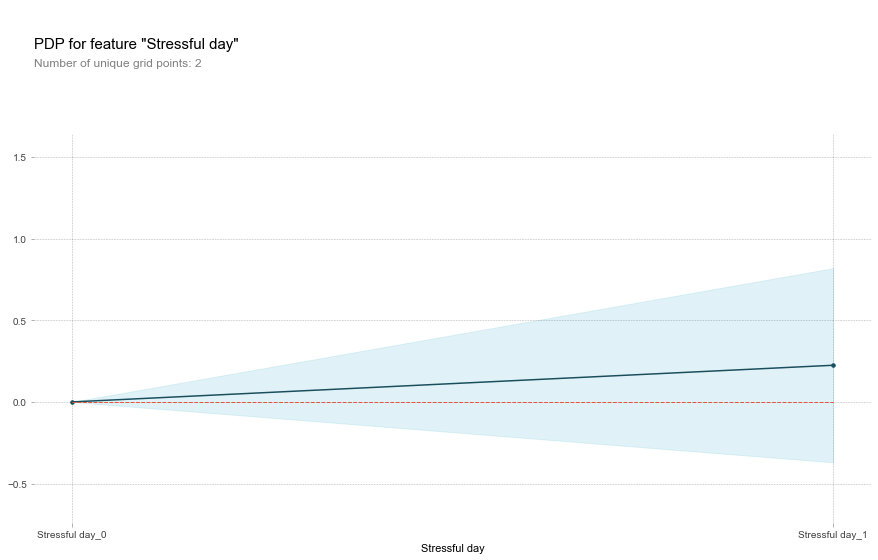

In [103]:
#PDP Plot Shows correlation between a feature and the target

feature = 'Stressful day'

isolate = pdp_isolate(
    pdp_model,
    dataset=X_train, 
    model_features=X_train.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

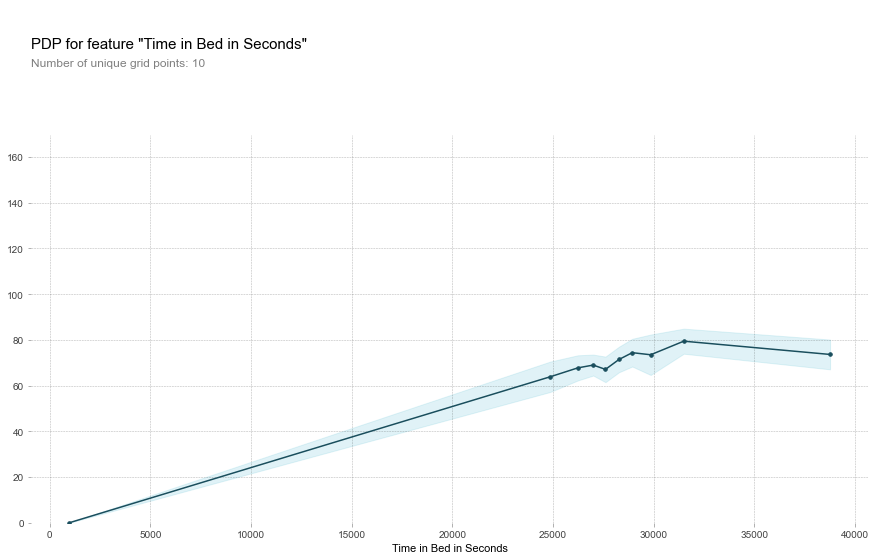

In [104]:
#PDP Plot Shows correlation between a feature and the target

feature = 'Time in Bed in Seconds'

isolate = pdp_isolate(
    pdp_model,
    dataset=X_train, 
    model_features=X_train.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

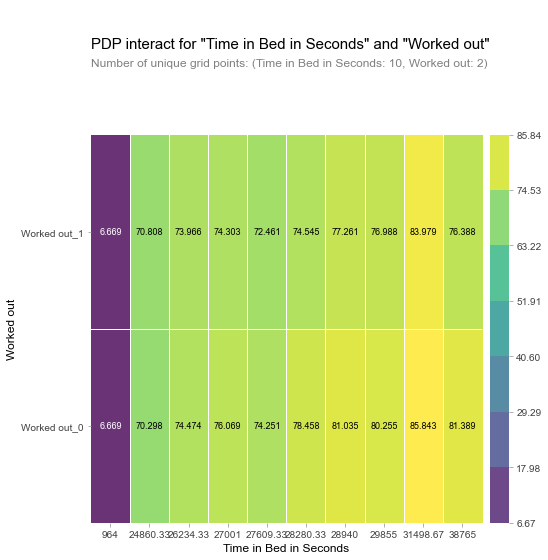

In [105]:
features = ['Time in Bed in Seconds', 'Worked out']

interact = pdp_interact(
    pdp_model,
    dataset=X_train,
    model_features=X_train.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

In [106]:
predict = model.predict(X_test)
predict [:100]

array([79.84166667, 73.39388889, 68.77944444, 74.16722222, 79.65388889,
       68.73166667, 75.96      , 74.61166667, 74.60888889, 76.60333333,
       75.57777778, 72.37166667, 81.44222222, 70.96722222, 76.44111111,
       77.09444444, 81.75222222, 82.55555556, 70.41777778,  7.63333333,
       69.155     , 86.54111111, 82.29777778, 75.54722222, 89.895     ,
       85.58944444, 77.10166667, 84.18222222, 69.60055556, 77.54333333,
       58.45111111, 74.90888889, 79.        , 77.35777778, 78.66888889,
       86.30055556, 73.705     , 71.52611111, 81.33555556, 73.93277778,
       73.07666667, 70.06888889, 81.69722222, 77.94666667, 89.83388889,
       52.19444444, 69.17777778, 75.53388889, 72.83722222, 69.24666667,
       77.54388889, 89.27388889, 75.64666667, 79.61611111, 84.65833333,
       72.35888889, 82.15777778, 71.92611111, 76.72      , 73.41444444,
       85.55166667, 89.025     , 78.03722222, 84.45222222, 73.805     ,
       74.96111111, 74.17833333, 52.34611111, 82.40277778, 83.06

In [107]:
# Step 1: Choose my feature
col = 'Time in Bed in Seconds'

# Step 2: Train model w/ ALL features

model_xgb.fit(X_train, y_train);

# Step 3: Evaluate model using Test Data.
print('XGBoost Test Accuracy:', model_xgb.score(X_test, y_test))

# Step 4: In VALIDATION DATA, permute the feature we're evaluating
X_test_perm = X_test.copy()
X_test_perm[col] = np.random.permutation(X_test_perm[col])

# Step 5: Calculate our error metric with the permuted data 
print(f'XGBoost Test Accuracy w "{col}" permuted:', 
       model_xgb.score(X_test_perm, y_test))

[10:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Test Accuracy: 0.05056179775280899
XGBoost Test Accuracy w "Time in Bed in Seconds" permuted: 0.0056179775280898875


In [108]:
perm_imp = permutation_importance(
    model_xgb,
    X_train, 
    y_train,
    n_repeats=5,
    n_jobs=-1,
    random_state=42
)

In [109]:
data = {'imp_mean': perm_imp['importances_mean'],
      'imp_std': perm_imp['importances_std']}

Sleep1 = pd.DataFrame(data, index=X_test.columns).sort_values('imp_mean')

In [110]:
Sleep1

,imp_mean,imp_std
Wake_up_MISSING,0.000000,0.000000
SleepNotes_MISSING,0.000000,0.000000
Ate late,0.001128,0.000564
Stressful day,0.009309,0.003408
HeartRate_MISSING,0.025670,0.004999
Wake up,0.052468,0.002877
Drank tea,0.052750,0.004146
Activity (steps)_MISSING,0.053597,0.008965
Worked out,0.058392,0.004513
Drank coffee,0.063188,0.005078


<AxesSubplot:>

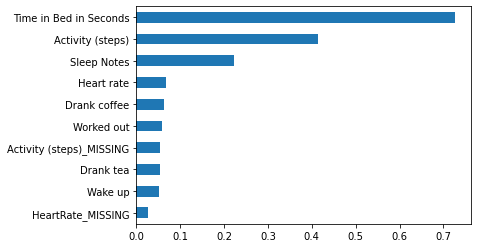

In [111]:
Sleep1['imp_mean'].tail(10).plot(kind='barh')

In [112]:
WebAppSleepCols = Sleep1.tail(7)
WebAppSleepCols

,imp_mean,imp_std
Activity (steps)_MISSING,0.053597,0.008965
Worked out,0.058392,0.004513
Drank coffee,0.063188,0.005078
Heart rate,0.068265,0.004853
Sleep Notes,0.222003,0.012508
Activity (steps),0.414104,0.009296
Time in Bed in Seconds,0.727221,0.008491


In [113]:
Colz = WebAppSleepCols.index.tolist()
Colz

['Activity (steps)_MISSING',
 'Worked out',
 'Drank coffee',
 'Heart rate',
 'Sleep Notes',
 'Activity (steps)',
 'Time in Bed in Seconds']

In [114]:
X_train_Filtered = X_train[Colz]
X_train_Filtered

,Activity (steps)_MISSING,Worked out,Drank coffee,Heart rate,Sleep Notes,Activity (steps),Time in Bed in Seconds
730,0,0,0,NaN,NaN,2429.0,30401.0
390,1,1,1,NaN,Drank coffee:Worked out,NaN,29551.0
118,1,1,1,64.0,Drank coffee:Drank tea:Worked out,NaN,28109.0
440,0,1,0,NaN,Drank tea:Worked out,11650.0,29272.0
309,1,0,1,NaN,Drank coffee,NaN,35244.0
...,...,...,...,...,...,...,...
106,1,1,1,52.0,Drank coffee:Drank tea:Worked out,NaN,28169.0
270,1,0,1,NaN,Drank coffee:Stressful day,NaN,27927.0
860,0,0,0,NaN,NaN,22.0,28613.0
435,0,1,0,NaN,Drank tea:Worked out,7025.0,27252.0


In [115]:
model_rfr2 = make_pipeline(OneHotEncoder(),
                         SimpleImputer(),
                         RandomForestRegressor(random_state=30,n_jobs=-1))

model_rfr2.fit(X_train_Filtered, y_train);

In [116]:
from joblib import dump
dump(model_rfr2, 'model.joblib', compress=True)

['model.joblib']

In [117]:
cat_cols = X_train_Filtered.select_dtypes(include='object').columns
for cat in cat_cols:
    print(cat)
    print(X_train_Filtered[cat].unique().tolist())

Sleep Notes
[nan, 'Drank coffee:Worked out', 'Drank coffee:Drank tea:Worked out', 'Drank tea:Worked out', 'Drank coffee', 'Drank coffee:Drank tea', 'Drank tea', 'Drank coffee:Stressful day', 'Drank coffee:Stressful day:Worked out', 'Ate late:Drank coffee', 'Drank tea:Stressful day:Worked out', 'Ate late:Drank coffee:Worked out', 'Drank coffee:Drank tea:Stressful day', 'Ate late:Drank coffee:Drank tea:Worked out', 'Drank coffee:Drank tea:Stressful day:Worked out', 'Ate late:Drank coffee:Drank tea', 'Ate late:Drank coffee:Drank tea:Stressful day', 'Worked out', 'Drank tea:Stressful day', 'Stressful day']


In [118]:
con_cols =  X_train_Filtered.select_dtypes(exclude='object').columns.tolist()
for con in con_cols:
    print( X_train_Filtered[con].describe())

count    709.000000
mean       0.465444
std        0.499157
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Activity (steps)_MISSING, dtype: float64
count    709.000000
mean       0.406206
std        0.491471
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Worked out, dtype: float64
count    709.000000
mean       0.582511
std        0.493493
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Drank coffee, dtype: float64
count    131.000000
mean      60.877863
std        7.490530
min       49.000000
25%       57.000000
50%       60.000000
75%       64.000000
max       98.000000
Name: Heart rate, dtype: float64
count      379.000000
mean      5208.134565
std       3096.434399
min         22.000000
25%       3212.000000
50%       5051.000000
75%       7133.000000
max      21870.000000
Name: Activity (steps), dtype: float